<a href="https://colab.research.google.com/github/BYU-Handwriting-Lab/GettingStarted/blob/egb/notebooks/ARUNetSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ARU-Net Segmentation

This notebook contains code for predicting baselines and seams in historical 
documents. It also contains code for segmenting images based on the seam and
baseline output images.

We follow the approach described in the paper,
[*A Two-Stage Method for Text Line Detection in Historical Documents*](https://arxiv.org/abs/1802.03345), in which they propose an architecture called the
ARU-Net.

The ARU-Net is an extension of the Deep U-Net as recorded in the paper,
[*U-Net: Convolutional Networks for Biomedical Image Segmentation*](https://arxiv.org/abs/1505.04597). The ARU-Net is different from the original U-Net in
the following ways:
* A spatial attention mechanism is added (A for attention)
* Residual blocks replace original convolutional blocks (R for Residual)
* The image is observed at multiple scale spaces

The code currently uses a naive approach to baseline clustering and as a result
is extremely slow. In the future, the second-stage as described in the above
paper should be implemented and updated here.

We extend the approach explained in the paper by training two ARU-Nets. One
for baseline detection and the other for seam detection. Using the output of
these two networks, we can produce line-level segmentations given an input
image.

### Diagrams

Diagrams as given in the paper, [*A Two-Stage Method for Text Line Detection in Historical Documents*](https://arxiv.org/abs/1802.03345).

Diagram of One Residual Block in the RU-Net Architecture

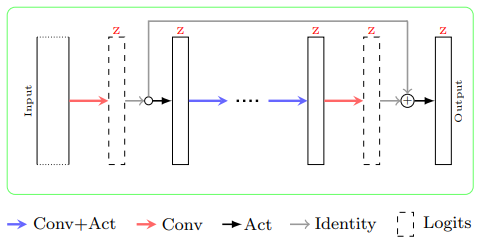

Diagram of the RU-Net Architecture

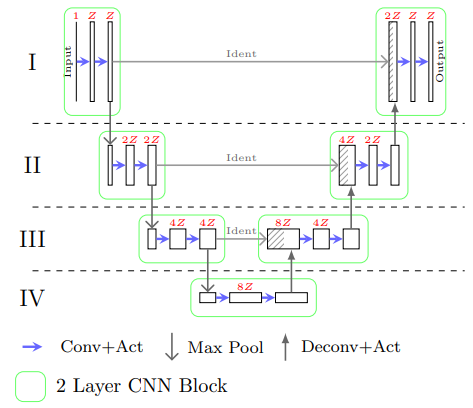

Diagram of the ARU-Net Architecture at three separate scale spaces

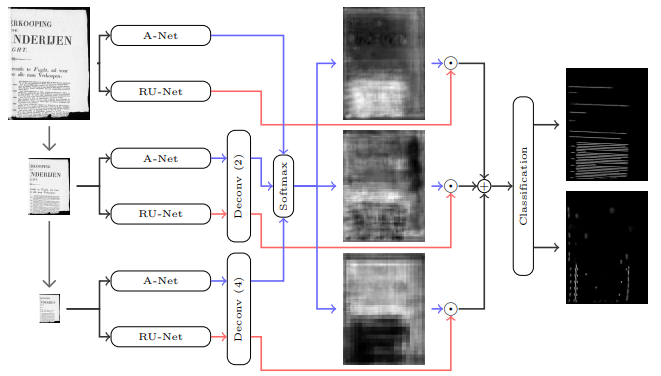

### Imports/Dependencies

Import the dependencies needed to run TensorFlow and to build the ARU-Net.

In [ ]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

# TensorFlow
import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow.keras.constraints as C
from tensorflow.keras import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l2


# Data Structures
import pandas as pd
import numpy as np
import json
import csv
import html
import numba as nb

# Python
import os
import gc
import string
import re
import time
import io
import sys
import random

# Match
import editdistance as ed

# Image/Plotting
import cv2
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from PIL import Image, ImageDraw
import IPython.display as display
from shapely.geometry import LineString, Point, Polygon, MultiPoint, MultiLineString
from shapely.ops import split
from sklearn.cluster import DBSCAN
from scipy.ndimage.filters import median_filter

# Colab (We can use this if we want to import files from Google Drive)
# from google.colab import drive
# drive.mount('/content/drive')

# Debugging
from tqdm import tqdm
from IPython.core.ultratb import AutoFormattedTB
__ITB__ = AutoFormattedTB(mode = 'Verbose',color_scheme='LightBg', tb_offset = 1)

Download 10 images from the French Records dataset from Google Drive.

In [ ]:
# ID = 10RM658zFHqrGx4ndaDiAwyJM_Qril3TV
# SEAMS ID = 1WBniZc_NS7mIYNxNm3rt7sJC3LaX2Tpv
# FILENAME = baseline_dataset.zip
# !wget -q --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=10RM658zFHqrGx4ndaDiAwyJM_Qril3TV' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=10RM658zFHqrGx4ndaDiAwyJM_Qril3TV" -O baseline_dataset.zip && rm -rf /tmp/cookies.txt
!wget -q --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1WBniZc_NS7mIYNxNm3rt7sJC3LaX2Tpv' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1WBniZc_NS7mIYNxNm3rt7sJC3LaX2Tpv" -O baseline_dataset.zip && rm -rf /tmp/cookies.txt
!unzip -q baseline_dataset.zip
!rm baseline_dataset.zip

In [ ]:
# ID = 13cJnJ27Fdq12-yJgBY_-e2GHG1iKJ5sZ
!wget -q --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=13cJnJ27Fdq12-yJgBY_-e2GHG1iKJ5sZ' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=13cJnJ27Fdq12-yJgBY_-e2GHG1iKJ5sZ" -O baseline_dataset.zip && rm -rf /tmp/cookies.txt
!unzip -q baseline_dataset.zip
!rm baseline_dataset.zip

Make sure it downloaded successfully

In [ ]:
!ls baseline_seams_dataset

baselines  images  seams


### Keras Sequence and TFRecord Dataset Creation

Create the Keras Sequence Class as a place to load images from the dataset.

In [ ]:
def random_augmentation(img, label):
    """
    Function to apply random augmentations to the image and label image

    :param img: The image to be transformed
    :param label: The label to be transformed
    :return: The transformed image and label
    """
    theta = 0
    tx = 0
    ty = 0
    zx = 1
    zy = 1
    shear = 0

    # Random Flip
    if random.randint(0, 2) == 0:
        img = tf.image.flip_left_right(img)
        label = tf.image.flip_left_right(label)
    # Random Rotate
    if random.randint(0, 1):  # .5
        theta = random.uniform(-5, 5)
    # Random Shear
    elif random.randint(0, 1):  # Only do shear if we haven't rotated
        shear = random.uniform(-5, 5)
    # Random Zoom
    if random.randint(0, 1) == 0:
        zx = random.uniform(.8, 1.2)
        zy = zx
    # Random Translation
    if random.randint(0, 1):
        tx = random.uniform(-35, 35)
        ty = random.uniform(-35, 35)

    # Apply Affine Transformation
    img = tf.keras.preprocessing.image.apply_affine_transform(img.numpy(), theta=theta, tx=tx, ty=ty, shear=shear,
                                                              zx=zx, zy=zy)
    label = tf.keras.preprocessing.image.apply_affine_transform(label.numpy(), theta=theta, tx=tx, ty=ty, shear=shear,
                                                                zx=zx, zy=zy)

    # Apply Random Brightness Transformation
    # if random.randint(0, 1):
        # img = tf.keras.preprocessing.image.random_brightness(img, (.01, 1.4))

    return img, label


def random_crop(img, mask, width, height):
  x = random.randint(0, img.shape[1] - width)
  y = random.randint(0, img.shape[0] - height)
  img = img[y:y+height, x:x+width]
  mask = mask[y:y+height, x:x+width]

  return img, mask


class BaselineSequence(tf.keras.utils.Sequence):
    """
    ARU-Sequence

    Keras Sequence class responsible for loading dataset in a TensorFlow compatible format.
    """
    def __init__(self, img_path, label_path=None, desired_size=(1024, 1536), augmentation_rate=1, mp_layers=10):
        """
        Set up paths and necessary variables.

        :param img_path: Path to the images
        :param label_path:
        :param desired_size:
        """
        self.img_path = img_path
        self.label_path = label_path
        self.augmentation_rate = augmentation_rate
        self.divisor = 2 ** mp_layers

        if not os.path.exists(self.img_path):
            raise Exception('Images do not exist in', self.img_path)
        if self.label_path is not None and not os.path.exists(self.label_path):
            raise Exception('Labels do not exist in', self.label_path)

        self.desired_size = desired_size
        self.imgs = os.listdir(self.img_path)
    
    def closest_multiple(self, value):
      q = value // self.divisor
      n1 = q * self.divisor
      n2 = (q + 1) * self.divisor

      if np.abs(n1 - value) < np.abs(n2 - value):
        return n1
      else:
        return n2

    def tensor_image(self, path, pil_format):
        """
        Load an image from the given path, resize it, and convert it to a tensor. The PIL format is helpful
        to control if the image should be binary, grayscale, rgb, etc.

        :param path: Full path to the image
        :param pil_format: The PIL format of the image to be loaded ('1':Binary, 'L':Grayscale, 'RGB':Color)
        :return: The image as tensor
        """
        img = Image.open(path)
        img = np.array(img.convert(pil_format), dtype=np.float32)
        img = tf.expand_dims(img, 2)
        height = self.closest_multiple(img.shape[0])
        width = self.closest_multiple(img.shape[1])
        img = tf.image.resize_with_pad(img, height, width)

        return img

    def __getitem__(self, index):
        """
        Indexing access to the Keras Sequence

        :param index: The index number of the image/label to be retrieved
        :return: The image as tensor and (possibly) label as tensor
        """
        img_index = index // self.augmentation_rate

        img = self.tensor_image(os.path.join(self.img_path, self.imgs[img_index]), pil_format="L")
        img = tf.image.per_image_standardization(img)  # Adjust image to have mean 0 and variance 1

        # FOR TRAINING
        # If a label_path was given, convert the label to a tensor and return it along with the image tensor
        if self.label_path is not None:
            label = self.tensor_image(os.path.join(self.label_path, self.imgs[img_index].split('.')[0] + '_gt.jpg'),
                                      pil_format="1")

            # Don't perform data augmentation the first time we see this image
            # if index % self.augmentation_rate != 0:
                # img, label = random_augmentation(img, label)

            return img, label

        # FOR INFERENCE
        # If no label was given, return the image tensor and the image name
        return img, self.imgs[index].split('.')[0]

    def __len__(self):
        """
        The number of items in the sequence
        :return: Length of the sequence
        """
        return len(self.imgs) * self.augmentation_rate

Show some example images of what the images look like, including the
ground-truth for baselines and seams.

(1024, 2048, 1)


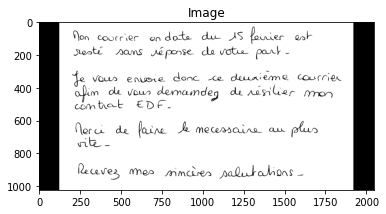

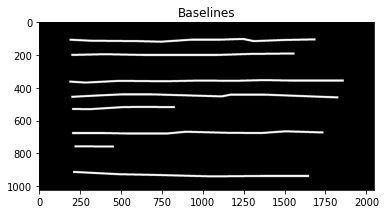

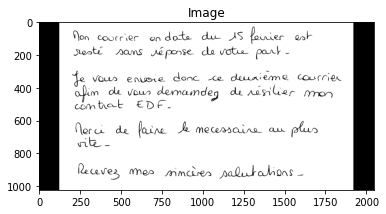

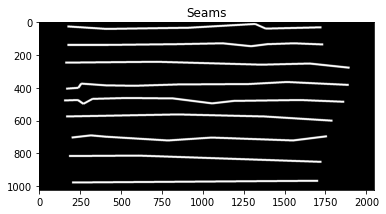

In [ ]:
# Note that with Augmentation in the Keras Sequence, baselines and seams won't match.
# This isn't a problem, because we train a baseline, seam model separately

baseline_sequence = BaselineSequence('/content/baseline_seams_dataset/images', '/content/baseline_seams_dataset/baselines', desired_size=(1024, 1536), augmentation_rate=1, mp_layers=10)
seam_sequence = BaselineSequence('/content/baseline_seams_dataset/images', '/content/baseline_seams_dataset/seams', desired_size=(1024, 1536), augmentation_rate=1, mp_layers=10)
img, baseline = baseline_sequence[3]
print(img.shape)
img_seam, seam = seam_sequence[3]
plt.title('Image')
plt.imshow(tf.squeeze(img), cmap='gray')
plt.pause(.1)
plt.title('Baselines')
plt.imshow(tf.squeeze(baseline), cmap='gray')
plt.pause(.1)
plt.title('Image')
plt.imshow(tf.squeeze(img_seam), cmap='gray')
plt.pause(.1)
plt.title('Seams')
plt.imshow(tf.squeeze(seam), cmap='gray')

Code that will convert data available in a Keras Sequence to TFRecord format.
TFRecord is much more efficient and allows for much faster training.

In [ ]:
def create_tfrecord_from_sequence(sequence, tfrecord_path):
  print('Started writing TFRecord...')

  writer = tf.io.TFRecordWriter(tfrecord_path)

  for index, (img, label) in enumerate(sequence):
    feature = {'label': _bytes_feature(tf.io.serialize_tensor(label)),
               'image': _bytes_feature(tf.io.serialize_tensor(img))}

    example = tf.train.Example(features=tf.train.Features(feature=feature))
    writer.write(example.SerializeToString())
    if index % 1000 == 0:
      print(str(index) + '/' + str(len(sequence)))
  
  print(str(len(sequence)) + '/' + str(len(sequence)))
  
  print('Finished: TFRecord created at', tfrecord_path)

def read_tfrecord(example_proto):
  feature_description = {
      'label': tf.io.FixedLenFeature((), tf.string),
      'image': tf.io.FixedLenFeature((), tf.string)
  }

  example = tf.io.parse_single_example(example_proto, feature_description)

  image = tf.io.parse_tensor(example['image'], out_type=tf.float32)
  label = tf.io.parse_tensor(example['label'], out_type=tf.float32)

  image.set_shape((None, None, 1))
  label.set_shape((None, None, 1))

  return image, label

def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value])) 

Make the actual conversion to TFRecord and store the resulting tfrecords as
*baseline.tfrecords* and *seams.tfrecords*.

In [ ]:
create_tfrecord_from_sequence(BaselineSequence('/content/baseline_seams_dataset/images', '/content/baseline_seams_dataset/baselines', desired_size=(1024, 1536), augmentation_rate=1, mp_layers=10), 'baseline.tfrecords')
create_tfrecord_from_sequence(BaselineSequence('/content/baseline_seams_dataset/images', '/content/baseline_seams_dataset/seams', desired_size=(1024, 1536), augmentation_rate=1, mp_layers=10), 'seam.tfrecords')

Started writing TFRecord...
0/52
52/52
Finished: TFRecord created at baseline.tfrecords
Started writing TFRecord...
0/52
52/52
Finished: TFRecord created at seam.tfrecords


Make sure we can deserialize the tfrecords file and get back an image and label

In [ ]:
def subsample(img, label):
  index = tf.random.uniform([], 0, 4, dtype=tf.int32)

  height = tf.shape(img)[0]
  width = tf.shape(img)[1]

  if index == 0:
    img = tf.image.resize(img, (height // 2, width // 2))
    label = tf.image.resize(label, (height // 2, width // 2))
  elif index == 1:
    img = tf.image.resize(img, (height // 2, width))
    label = tf.image.resize(label, (height // 2, width))
  elif index == 2:
    img = tf.image.resize(img, (height, width // 2))
    label = tf.image.resize(label, (height, width // 2))

  return img, label

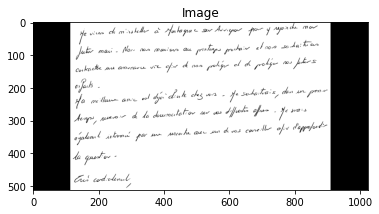

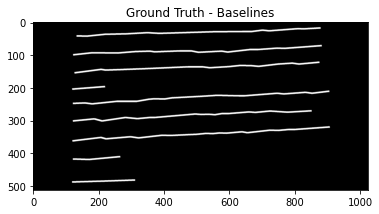

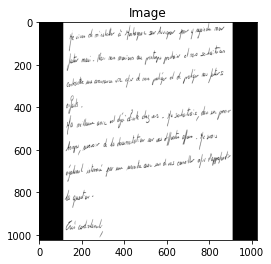

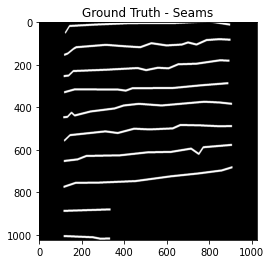

In [ ]:
baseline_dataset = tf.data.TFRecordDataset('baseline.tfrecords')
seam_dataset = tf.data.TFRecordDataset('seam.tfrecords')

parsed_baseline_dataset = baseline_dataset.map(read_tfrecord).map(subsample)
parsed_seam_dataset = seam_dataset.map(read_tfrecord).map(subsample)

for baseline_features, seam_features in zip(parsed_baseline_dataset.skip(5).take(1), parsed_seam_dataset.skip(5).take(1)):
  plt.title('Image')
  plt.imshow(tf.squeeze(baseline_features[0]), cmap='gray')
  plt.pause(.1)

  plt.title('Ground Truth - Baselines')
  plt.imshow(tf.squeeze(baseline_features[1]), cmap='gray')
  plt.pause(.1)

  plt.title('Image')
  plt.imshow(tf.squeeze(seam_features[0]), cmap='gray')
  plt.pause(.1)

  plt.title('Ground Truth - Seams')
  plt.imshow(tf.squeeze(seam_features[1]), cmap='gray')
  plt.pause(.1)

### Model Creation

We now create the model according to the details described in the paper.

A helper module with convolution, batch_norm, activation, dropout, and max_pool
that we'll repeatedly use in the A-Net.

In [ ]:
class ConvBnActDropMp(Model):
  def __init__(self, filters, activation=L.ReLU, dropout_rate=0.3, max_pool=True, name="ConvBnActDropMp"):
    super(ConvBnActDropMp, self).__init__()

    self.model = tf.keras.Sequential(name=name)
    self.model.add(L.Conv2D(filters, kernel_size=(4, 4), padding='same', kernel_regularizer=l2(0.0005)))
    # self.model.add(L.BatchNormalization(renorm=True))
    self.model.add(activation())

    if dropout_rate != 0.0:
      self.model.add(L.Dropout(dropout_rate))
    
    if max_pool:
      self.model.add(L.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='same'))

  def call(self, x, **kwargs):
    return self.model(x, **kwargs)

class DeconvBnActDrop(Model):
  def __init__(self, filters, kernel_size=(2,2), strides=(2,2), activation=L.ReLU, dropout_rate=0.3, name="DeconvBnActDrop"):
    super(DeconvBnActDrop, self).__init__()

    self.model = tf.keras.Sequential(name=name)
    self.model.add(L.Conv2DTranspose(filters, kernel_size=kernel_size, strides=strides, padding='same', kernel_regularizer=l2(0.0005)))
    # self.model.add(L.BatchNormalization(renorm=True))
    self.model.add(activation())

    if dropout_rate is not None and dropout_rate != 0.0:
      self.model.add(L.Dropout(dropout_rate))

  def call(self, x, **kwargs):
    return self.model(x, **kwargs)

The residual block used in the RU-Net and the implementation of the diagram
outlined above.

In [ ]:
class ResidualBlock(Model):
  def __init__(self, filters, activation=L.ReLU, dropout_rate=0.3):
    super(ResidualBlock, self).__init__()

    self.filters = filters
    self.act_final = activation()

    self.shortcut = L.Conv2D(filters, kernel_size=(1, 1), use_bias=False)

    self.conv = tf.keras.Sequential()
    self.conv.add(L.Conv2D(filters, kernel_size=(3, 3), padding='same', kernel_regularizer=l2(0.0005)))
    # self.conv.add(L.BatchNormalization(renorm=True))
    self.conv.add(activation())
    if dropout_rate is not None and dropout_rate != 0.0:
      self.conv.add(L.Dropout(dropout_rate))

    self.conv.add(L.Conv2D(filters, kernel_size=(3, 3), padding='same', kernel_regularizer=l2(0.0005)))
    # self.conv.add(L.BatchNormalization(renorm=True))
    self.conv.add(activation())
    if dropout_rate is not None and dropout_rate != 0.0:
      self.conv.add(L.Dropout(dropout_rate))

    self.conv.add(L.Conv2D(filters, kernel_size=(3, 3), padding='same', kernel_regularizer=l2(0.0005)))
    # self.conv.add(L.BatchNormalization(renorm=True))
    self.conv.add(activation())
    if dropout_rate is not None and dropout_rate != 0.0:
      self.conv.add(L.Dropout(dropout_rate))

    self.conv4 = L.Conv2D(filters, kernel_size=(3, 3), padding='same', kernel_regularizer=l2(0.0005))

  def call(self, x, **kwargs):
    # Add shortcut if necessary
    if x.shape[-1] != self.filters: # Channel Dimension
      x = self.shortcut(x)

    # Send through the conv block 
    out = self.conv(x, **kwargs)

    # Element-Wise Addition
    out = tf.math.add(out, x)

    # Final Activation
    out = self.act_final(out)

    return out

A-Net Architecture - The spatial attention mechanism that will allow the network
to focus on certain parts of the document at varying scale spaces. This is a
slight adaptation from the original paper. We are using a sigmoid instead of a
softmax.

In [ ]:
class ANet(Model):
  def __init__(self, activation=L.ReLU, dropout_rate=0.3):
    super(ANet, self).__init__(name='A-Net')

    self.conv1 = ConvBnActDropMp(12, activation=activation, dropout_rate=dropout_rate, max_pool=True, name='conv1')
    self.conv2 = ConvBnActDropMp(16, activation=activation, dropout_rate=dropout_rate, max_pool=True, name='conv2')
    self.conv3 = ConvBnActDropMp(32, activation=activation, dropout_rate=dropout_rate, max_pool=True, name='conv3')
    self.conv4 = ConvBnActDropMp(2, activation=activation, dropout_rate=dropout_rate, max_pool=False, name='conv4')

  def call(self, x, **kwargs):
    out = self.conv1(x, **kwargs)
    out = self.conv2(out, **kwargs)
    out = self.conv3(out, **kwargs)
    out = self.conv4(out, **kwargs)

    return out

RU-Net Architecture - The U-Net architecture with residual blocks and padding
which allow the image to have the same spatial dimensions thoughout the model.

In [ ]:
class RUNet(Model):
  def __init__(self, initial_filters=8, activation=L.ReLU, dropout_rate=0.3):
    super(RUNet, self).__init__(name='RU-Net')

    self.block1 = ResidualBlock(filters=initial_filters, activation=activation, dropout_rate=dropout_rate)
    self.block2 = ResidualBlock(filters=initial_filters * 2, activation=activation, dropout_rate=dropout_rate)
    self.block3 = ResidualBlock(filters=initial_filters * 4, activation=activation, dropout_rate=dropout_rate)
    self.block4 = ResidualBlock(filters=initial_filters * 8, activation=activation, dropout_rate=dropout_rate)
    self.block5 = ResidualBlock(filters=initial_filters * 16, activation=activation, dropout_rate=dropout_rate)
    self.block6 = ResidualBlock(filters=initial_filters * 32, activation=activation, dropout_rate=dropout_rate)
    self.block7 = ResidualBlock(filters=initial_filters * 16, activation=activation, dropout_rate=dropout_rate)
    self.block8 = ResidualBlock(filters=initial_filters * 8, activation=activation, dropout_rate=dropout_rate)
    self.block9 = ResidualBlock(filters=initial_filters * 4, activation=activation, dropout_rate=dropout_rate)
    self.block10 = ResidualBlock(filters=initial_filters * 2, activation=activation, dropout_rate=dropout_rate)
    self.block11 = ResidualBlock(filters=initial_filters, activation=activation, dropout_rate=dropout_rate)

    self.conv_final = L.Conv2D(filters=2, kernel_size=(1, 1), padding='same')

    self.mp1 = L.MaxPooling2D(pool_size=(2, 2), padding='same')
    self.mp2 = L.MaxPooling2D(pool_size=(2, 2), padding='same')
    self.mp3 = L.MaxPooling2D(pool_size=(2, 2), padding='same')
    self.mp4 = L.MaxPooling2D(pool_size=(2, 2), padding='same')
    self.mp5 = L.MaxPooling2D(pool_size=(2, 2), padding='same')

    self.deconv1 = DeconvBnActDrop(initial_filters * 16, kernel_size=(3, 3), strides=(2, 2), activation=activation, dropout_rate=dropout_rate)
    self.deconv2 = DeconvBnActDrop(initial_filters * 8, kernel_size=(3, 3), strides=(2, 2), activation=activation, dropout_rate=dropout_rate)
    self.deconv3 = DeconvBnActDrop(initial_filters * 4, kernel_size=(3, 3), strides=(2, 2), activation=activation, dropout_rate=dropout_rate)
    self.deconv4 = DeconvBnActDrop(initial_filters * 2, kernel_size=(3, 3), strides=(2, 2), activation=activation, dropout_rate=dropout_rate)
    self.deconv5 = DeconvBnActDrop(initial_filters * 1, kernel_size=(3, 3), strides=(2, 2), activation=activation, dropout_rate=dropout_rate)

  def call(self, x, **kwargs):
    # Down
    block1_out = self.block1(x, **kwargs)
    block2_in = self.mp1(block1_out)

    block2_out = self.block2(block2_in, **kwargs)
    block3_in = self.mp2(block2_out)

    block3_out = self.block3(block3_in, **kwargs)
    block4_in = self.mp3(block3_out)

    block4_out = self.block4(block4_in, **kwargs)
    block5_in = self.mp4(block4_out)

    block5_out = self.block5(block5_in, **kwargs)
    block6_in = self.mp5(block5_out)

    # Bottom
    block6_out = self.block6(block6_in, **kwargs)

    # Up
    block7_in = self.deconv1(block6_out)
    block7_out = self.block7(tf.concat((block7_in, block5_out), axis=3), **kwargs)

    block8_in = self.deconv2(block7_out)
    block8_out = self.block8(tf.concat((block8_in, block4_out), axis=3), **kwargs)

    block9_in = self.deconv3(block8_out)
    block9_out = self.block9(tf.concat((block9_in, block3_out), axis=3), **kwargs)

    block10_in = self.deconv4(block9_out)
    block10_out = self.block10(tf.concat((block10_in, block2_out), axis=3), **kwargs)

    block11_in = self.deconv5(block10_out)
    block11_out = self.block11(tf.concat((block11_in, block1_out), axis=3), **kwargs)

    # Final Conv to get down to 1 channel
    final_out = self.conv_final(block11_out)

    return final_out

ARU-Net Architecture - The combination of the A-Net and RU-Net architectures.
Multiple ARU-Nets are used at varying scale spaces.

In [ ]:
class ARUNet(Model):
  def __init__(self, activation=L.ReLU, runet_initial_filters=8, dropout_rate=0.0):
    super(ARUNet, self).__init__()

    # Scale 1 (Normal Size)
    self.anet = ANet(activation=activation, dropout_rate=dropout_rate)
    self.runet = RUNet(activation=activation, initial_filters=runet_initial_filters, dropout_rate=dropout_rate)

    # Scale 2
    self.ap1 = L.AveragePooling2D(pool_size=(2,2))
    self.a_deconv1 = DeconvBnActDrop(1, kernel_size=(2, 2), strides=(2, 2), dropout_rate=dropout_rate)
    self.ru_deconv1 = DeconvBnActDrop(1, kernel_size=(2, 2), strides=(2, 2), dropout_rate=dropout_rate)

    # Scale 3
    self.ap2 = L.AveragePooling2D(pool_size=(2, 2))
    self.a_deconv2 = DeconvBnActDrop(1, kernel_size=(2, 2), strides=(4, 4), dropout_rate=dropout_rate)
    self.ru_deconv2 = DeconvBnActDrop(1, kernel_size=(2, 2), strides=(4, 4), dropout_rate=dropout_rate)

    # Scale 4
    self.ap3 = L.AveragePooling2D(pool_size=(2, 2))
    self.a_deconv3 = DeconvBnActDrop(1, kernel_size=(2, 2), strides=(8, 8), dropout_rate=dropout_rate)
    self.ru_deconv3 = DeconvBnActDrop(1, kernel_size=(2, 2), strides=(8, 8), dropout_rate=dropout_rate)

    # Scale 5
    self.ap4 = L.AveragePooling2D(pool_size=(2, 2))
    self.a_deconv4 = DeconvBnActDrop(1, kernel_size=(2, 2), strides=(16, 16), dropout_rate=dropout_rate)
    self.ru_deconv4 = DeconvBnActDrop(1, kernel_size=(2, 2), strides=(16, 16), dropout_rate=dropout_rate)

    self.softmax = L.Softmax(axis=3)

  def call(self, x, **kwargs):
    # Scale 1
    anet1_out = self.anet(x, **kwargs)
    runet1_out = self.runet(x, **kwargs)
    anet1_out = self.softmax(anet1_out)

    arunet1_out = tf.math.multiply(anet1_out, runet1_out)

    # Scale 2
    x2 = self.ap1(x)  # Rescale with average pooling

    anet2_out = self.anet(x2, **kwargs)  # Send through Attention Net
    runet2_out = self.runet(x2, **kwargs)  # Send through Residual U-Net

    anet2_out = self.a_deconv1(anet2_out, **kwargs)  # Deconvolve to normal image size
    runet2_out = self.ru_deconv1(runet2_out, **kwargs)
    anet2_out = self.softmax(anet2_out)  # Apply softmax to A-Net

    arunet2_out = tf.math.multiply(anet2_out, runet2_out)  # Combine A/RU

    # Scale 3
    x3 = self.ap2(x2)

    anet3_out = self.anet(x3, **kwargs)
    runet3_out = self.runet(x3, **kwargs)

    anet3_out = self.a_deconv2(anet3_out, **kwargs)
    runet3_out = self.ru_deconv2(runet3_out, **kwargs)
    anet3_out = self.softmax(anet3_out)

    arunet3_out = tf.math.multiply(anet3_out, runet3_out)

    # Scale 4
    x4 = self.ap3(x3)

    anet4_out = self.anet(x4, **kwargs)
    runet4_out = self.runet(x4, **kwargs)

    anet4_out = self.a_deconv3(anet4_out, **kwargs)
    runet4_out = self.ru_deconv3(runet4_out, **kwargs)
    anet4_out = self.softmax(anet4_out)

    arunet4_out = tf.math.multiply(anet4_out, runet4_out)

    # Scale 5
    x5 = self.ap4(x4)

    anet5_out = self.anet(x5, **kwargs)
    runet5_out = self.runet(x5, **kwargs)

    anet5_out = self.a_deconv4(anet5_out, **kwargs)
    runet5_out = self.ru_deconv4(runet5_out, **kwargs)
    anet5_out = self.softmax(anet5_out)

    arunet5_out = tf.math.multiply(anet5_out, runet5_out)

    # Element-Wise Summation
    arunet_out = arunet1_out + arunet2_out + arunet3_out + arunet4_out + arunet5_out

    # Use softmax to give confidence level
    arunet_out = self.softmax(arunet_out)

    return arunet_out

Test a sample image just to make sure it works. Make a prediction (It will
likely be random noise since our model isn't trained yet).

In [ ]:
def augment(img, label):
  mix = tf.concat((img, label), axis=2)

  if tf.random.uniform((), 0, 4, dtype=tf.int32) != 0:
    crop_height = tf.random.uniform((), 768, 1025, dtype=tf.int32)
    crop_width = tf.random.uniform((), 1024, 1280, dtype=tf.int32)

    height = int(tf.shape(img)[0])
    width = int(tf.shape(img)[1])
    mix = tf.image.random_crop(mix, (crop_height, crop_width, 2))
    mix = tf.image.resize_with_pad(mix, height, width)

  mix = tf.image.random_flip_left_right(mix)

  return mix[:, :, 0], mix[:, :, 1]  
  # return tf.slice(newmix, [0, 0, 0], [height, width, 1]), tf.slice(newmix, [0, 0, 1], [height, width, 1])

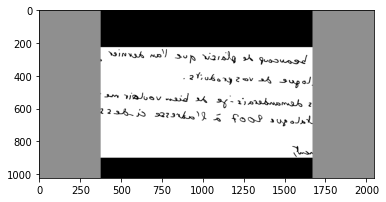

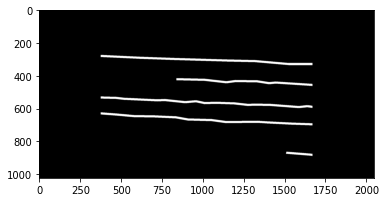

In [ ]:
newx, newy = augment(x, y)
plt.imshow(tf.squeeze(newx), cmap='gray')
plt.pause(.1)

plt.imshow(tf.squeeze(newy), cmap='gray')
plt.pause(.1)

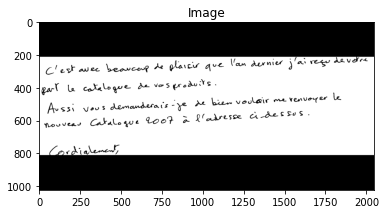

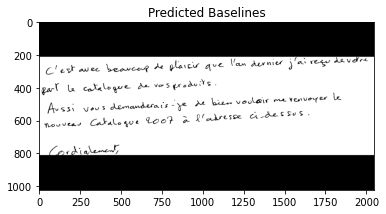

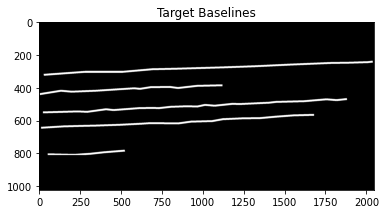

In [ ]:
baseline_sequence = BaselineSequence('/content/baseline_seams_dataset/images', '/content/baseline_seams_dataset/baselines', desired_size=(1024, 1536), augmentation_rate=1, mp_layers=10)
model = ARUNet()
x, y = baseline_sequence[2]
plt.title('Image')
plt.imshow(tf.squeeze(x), cmap='gray')
plt.pause(.1)

out = model(tf.expand_dims(x, 0))
plt.title('Predicted Baselines')
plt.imshow(tf.squeeze(tf.argmax(out, axis=3)), cmap='gray')
plt.pause(.1)
plt.title('Target Baselines')
plt.imshow(tf.squeeze(y), cmap='gray')
plt.pause(.1)

Let's see if we can calculate the loss and intersection over union between the
predicted and ground truth images.

In [ ]:
obj = tf.keras.losses.SparseCategoricalCrossentropy()
pred_loss = obj(tf.squeeze(y), tf.squeeze(out))

print('Prediction Loss:', pred_loss.numpy())
print('Regularization Loss:', tf.add_n(model.losses).numpy())

Prediction Loss: 0.7458142
Regularization Loss: 1.3189815


In [ ]:
iou = tf.keras.metrics.MeanIoU(num_classes=2)
iou_result = iou(tf.expand_dims(y, axis=0), tf.argmax(out, axis=3)).numpy()

print('Intersection over Union (IoU):', iou_result)

Intersection over Union (IoU): 0.2499976


Print a summary of the model

In [ ]:
model.summary()

Model: "aru_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
A-Net (ANet)                 multiple                  12542     
_________________________________________________________________
RU-Net (RUNet)               multiple                  3430626   
_________________________________________________________________
average_pooling2d (AveragePo multiple                  0         
_________________________________________________________________
deconv_bn_act_drop_5 (Deconv multiple                  9         
_________________________________________________________________
deconv_bn_act_drop_6 (Deconv multiple                  9         
_________________________________________________________________
average_pooling2d_1 (Average multiple                  0         
_________________________________________________________________
deconv_bn_act_drop_7 (Deconv multiple                  9   

### Training

We now train the ARU-Net using the dataset provided above.

We place our training loop and necessary variables inside the Train
class so we avoid nasty scope issues that can occur when using
@tf.function.

In [ ]:
class Train:
  def __init__(self, img_path, label_path, tfrecords_path='baseline.tfrecords', epochs=500):
    self.epochs = epochs
    self.batch_size = 1 # Paper had batch size of 1 - should increase to much more here though

    dataset_size = len(BaselineSequence(img_path=img_path, label_path=label_path, augmentation_rate=1))
    self.val_dataset_size = int(.2 * dataset_size)
    self.train_dataset_size = dataset_size - self.val_dataset_size

    dataset = tf.data.TFRecordDataset(tfrecords_path).map(read_tfrecord)
    self.val_dataset = dataset.take(self.val_dataset_size).batch(self.batch_size)
    self.train_dataset = dataset.skip(self.val_dataset_size).map(subsample).batch(self.batch_size)

    self.model = ARUNet()
    self.optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-3)
    self.objective = tf.keras.losses.SparseCategoricalCrossentropy()

    self.train_loss = tf.keras.metrics.Mean(name='train_loss')
    self.val_loss = tf.keras.metrics.Mean(name='val_loss')
    self.train_iou = tf.keras.metrics.MeanIoU(num_classes=2, name="train_iou")
    self.val_iou = tf.keras.metrics.MeanIoU(num_classes=2, name="val_iou")

    # Learning_Rate_Decay_Per_Epoch: 0.985
    # Weight decay on L2 norm: 0.0005
    # Exponential moving average on the model weights: 0.9995

  @tf.function(experimental_relax_shapes=True)
  def train_step(self, images, labels):
    with tf.GradientTape() as tape:
      predictions = self.model(images, training=True)
      loss = self.objective(labels, predictions)
      # loss += tf.add_n(self.model.losses)
    
    gradients = tape.gradient(loss, self.model.trainable_variables)
    self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
    self.train_loss(loss)
    self.train_iou(labels, tf.argmax(predictions, axis=3))
  
  @tf.function(experimental_relax_shapes=True)
  def validation_step(self, images, labels):
    predictions = self.model(images, training=False)
    loss = self.objective(labels, predictions)
    # loss += tf.add_n(self.model.losses)

    self.val_loss(loss)
    self.val_iou(labels, tf.argmax(predictions, axis=3))

  def __call__(self):
    try:
      train_losses, val_losses = [], []
      train_ious, val_ious = [], []

      for epoch in range(self.epochs):
        # Reset our metrics for each epoch
        self.train_loss.reset_states()
        self.val_loss.reset_states()
        self.train_iou.reset_states()
        self.val_iou.reset_states()

        # Memory Cleanup
        gc.collect()

        # Train Step
        train_loop = tqdm(total=self.train_dataset_size//self.batch_size, position=0, leave=True)
        for images, labels in self.train_dataset:
          self.train_step(images, labels)
          train_loop.set_description('Train - Epoch: {}, Loss: {:.4f}, IoU: {:.4f}'.format(epoch, self.train_loss.result(), self.train_iou.result()))
          train_loop.update(1)
        train_loop.close()

        # Validation Step
        val_loop = tqdm(total=self.val_dataset_size//self.batch_size, position=0, leave=True)
        for images, labels in self.val_dataset:
          self.validation_step(images, labels)
          val_loop.set_description('Val   - Epoch: {}, Loss: {:.4f}, IoU: {:.4f}'.format(epoch, self.val_loss.result(), self.val_iou.result()))
          val_loop.update(1)
        val_loop.close()

        train_losses.append(self.train_loss.result())
        val_losses.append(self.val_loss.result())
        train_ious.append(self.train_iou.result())
        val_ious.append(self.val_iou.result())
    except:
      __ITB__()
    finally:
      return self.model, (train_losses, val_losses), (train_ious, val_ious)

Train the ARU-Net for Baseline-Detection.

In [ ]:
train = Train('/content/baseline_seams_dataset/images', '/content/baseline_seams_dataset/baselines', tfrecords_path='baseline.tfrecords', epochs=80)
baseline_model, baseline_losses, baseline_ious = train()

Train another ARU-Net for Seam-Detection.

In [ ]:
train = Train('/content/baseline_seams_dataset/images', '/content/baseline_seams_dataset/seams', tfrecords_path='seam.tfrecords', epochs=200)
seam_model, seam_losses, seam_ious = train()

### Training Results

Function to help us plot metrics we kept track of during training.

In [ ]:
def plot(title, metrics_array):
  plt.title(title)
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.plot(metrics_array[0], label='Train')
  plt.plot(metrics_array[1], label='Val')
  plt.legend()
  plt.show()
  plt.pause(.1)

Graph our loss curve to see how the model learned over time.

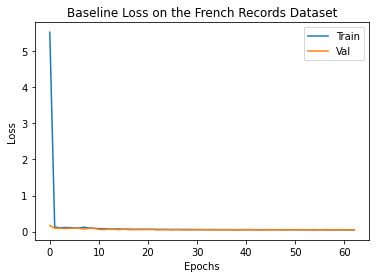

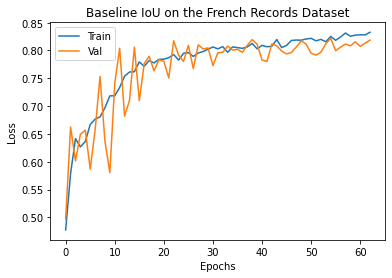

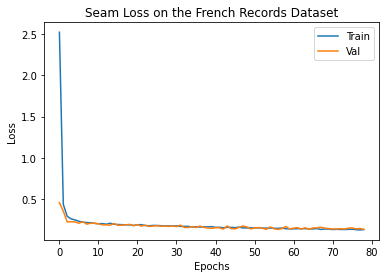

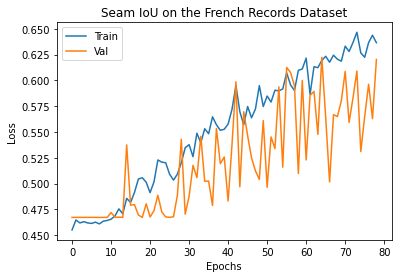

In [ ]:
plot('Baseline Loss on the French Records Dataset', baseline_losses)
plot('Baseline IoU on the French Records Dataset', baseline_ious)
plot('Seam Loss on the French Records Dataset', seam_losses)
plot('Seam IoU on the French Records Dataset', seam_ious)

### Save the Pre-trained Model (if desired)

Save the model weights to use at a future time. With credentials to the BYU
Handwriting Lab Google Drive, you can run this code and weights will be placed
there for future use.

In [ ]:
baseline_model.save_weights('arunet_baselines/run1')
seam_model.save_weights('arunet_seams/run1')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!cp -r 'arunet_baselines/' '/content/drive/My Drive/'
!cp -r 'arunet_seams/' '/content/drive/My Drive/'

### Load a Pretrained Model (if desired)

There are pre-trained weights on the BYU Handwriting Lab Google Drive. With,
the credentials, you can run this code to load the pre-trained weights and
start making predictions immediately.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!cp -r '/content/drive/My Drive/arunet_baselines' '/content/arunet_baselines'
!cp -r '/content/drive/My Drive/arunet_seams' '/content/arunet_seams'

baseline_model = ARUNet()
seam_model = ARUNet()
baseline_model.load_weights('/content/arunet_baselines/run1')
seam_model.load_weights('/content/arunet_seams/run1')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Segmenting

In [ ]:
def segment_from_predictions(original_image, baseline_prediction, seam_prediction, filename, step_size=1,
                             save_images=True, plot_images=False, save_path='./data/out/snippets'):
    """
    Segment the baseline and seam predictions and write the segments to the specified path.

    :param original_image: The original image to be segmented
    :param baseline_prediction: The predicted baselines (ARU-Net output)
    :param seam_prediction: The predicted seams (ARU-Net output)
    :param filename: The name of the file that is being segmented
    :param step_size: How many columns along the baseline to look at when searching the seam image to find
                      the bounding polygon
    :param save_images: Whether or not to save the images that are segmented
    :param plot_images: Whether or not to plot the images that are segmented
    :param save_path: The path to save the images to
    :return: None
    """
    original_image = tf.squeeze(original_image).numpy()
    # baseline_image = tf.squeeze(tf.argmax(baseline_prediction, axis=3)).numpy()
    baseline_image = tf.squeeze(baseline_prediction[:, :, :, 1])
    seam_image = tf.squeeze(seam_prediction[:, :, :, 1])

    sharpened_baseline_image = sharpen_image(baseline_image)
    sharpened_seam_image = sharpen_image(seam_image)

    baselines = cluster(sharpened_baseline_image)
    # baselines = sort_lines(baselines, original_image.shape)

    # Search the cleaned-up seam image for upper/lower seams
    # Create a polygon around the line based on the seam data
    polygons = []
    for baseline in baselines:
        seam_top = []
        seam_top_founds = []
        seam_bottom = []
        seam_bottom_founds = []
        for index, point in enumerate(baseline):
            if index % step_size == 0:
                seam_top_point, seam_top_found = search_up(point, sharpened_seam_image)
                seam_bottom_point, seam_bottom_found = search_down(point, sharpened_seam_image)

                seam_top.append(seam_top_point)
                seam_bottom.append(seam_bottom_point)

                seam_top_founds.append(seam_top_found)
                seam_bottom_founds.append(seam_bottom_found)

        seam_top_clean = clean_seam(seam_top, seam_top_founds)
        seam_bottom_clean = clean_seam(seam_bottom, seam_bottom_founds)

        if len(seam_top_clean) != 0 and len(seam_bottom_clean) != 0:
            polygons.append(np.concatenate((seam_top_clean, seam_bottom_clean[::-1])))

    # Iterate over all baselines/polygons - segment, dewarp, and crop
    for index, (poly, baseline) in enumerate(zip(polygons, baselines)):
        segment, segment_baseline = segment_from_polygon(Polygon(poly), Image.fromarray(np.invert(original_image.astype(np.uint8))), baseline)
        dewarped_segment = dewarp(segment, segment_baseline)
        final_segment = final_crop(dewarped_segment)

        snippet_name = filename + '_' + str(index) + '.jpg'

        if save_images:
            save_image(final_segment, save_path, snippet_name)
        if plot_images:
            plot_image(final_segment, snippet_name)


def sharpen_image(image_prediction, thresh_start=.1, thresh_end=.9, filter_sizes=(4, 4, 3)):
    """
    Sharpen an image by using a serious of median filters.

    :param image_prediction: The image prediction
    :param thresh_start: Threshold at start before filtering for binarization
    :param thresh_end: Threshold at end after filtering for binarization
    :param filter_sizes: Sizes of the median filters to be used
    :return: The sharpened image
    """
    clean_seam_image = np.where(image_prediction > thresh_start, 1, 0)

    # Perform filtering
    for kernel_size in filter_sizes:
        clean_seam_image = median_filter(clean_seam_image, size=kernel_size)

    clean_seam_image = np.where(clean_seam_image > thresh_end, 1, 0)

    return clean_seam_image


def cluster(image, min_points=160):
    """
    Cluster the points on the image using the DBSCAN clustering algorithm. Perform some form of skeletonization.

    :param image: The predicted baseline image
    :param min_points: The minimum number of line pixels (after skeletonization) that must be included for the cluster
                       to be considered.
    :return: The baselines as a list of lists of points
    """
    # Perform clustering according to the DBSCAN algorithm
    points = tf.where(image).numpy()  # Find the coordinates that are non-zero
    clustered_points = DBSCAN(eps=10, min_samples=5).fit(points)

    # Create a list of lists to hold the clusters based on the labeling
    unique_labels = np.unique(clustered_points.labels_)
    if -1 in unique_labels:
        num_labels = len(unique_labels) - 1
    else:
        num_labels = len(unique_labels)

    clusters = [[] for _ in range(num_labels)]

    # Place points corresponding to a given label into their own list
    for label, point in zip(clustered_points.labels_, points):
        if label != -1:
            clusters[label].append(point.tolist())

    # Sort the clusters from left to right
    for c in clusters:
        c.sort(key=lambda p: p[1])

    # Perform non-maximum suppression so we only have one point per column
    nms_clusters = []
    for c in clusters:  # For each cluster
        c_cluster = []
        current = -1
        for point in c:  # For each point in a cluster
            if point[1] > current:
                c_cluster.append(point)
                current = point[1]
        nms_clusters.append(c_cluster)

    # Filter out minimum points
    nms_clusters = list(filter(lambda cl: len(cl) > min_points, nms_clusters))

    return nms_clusters


def search_up(point, image, max_height=150, min_height=10):
    """
    Search for a seam point above the given baseline point.

    :param point: The baseline point to be searched from
    :param image: The image to be searched
    :param max_height: The max number of pixels to be searched until the max point is returned
    :param min_height: The min number of pixels to be searched before a seam point can be considered found
    :return: The found seam point
    """
    y, x = point
    y_start = y

    while y > 0 and (image[y][x] == 0 or y_start - y < min_height):
        y -= 1
        if y_start - y > max_height:
            return [x, y], False  # Return False if no seam was found
    seam_begin = y

    while y > 0 and y_start - y <= max_height * 2 and (image[y][x] == 1 or y_start - y < min_height):
        y -= 1
    seam_end = y

    final_y = np.floor((seam_begin + seam_end) / 2)

    return [x, final_y], True


def search_down(point, image, max_height=100, min_height=6):
    """
    Search for a seam point below the given baseline point.

    :param point: The baseline point to be searched from
    :param image: The image to be searched
    :param max_height: The max number of pixels to be searched until the max point is returned
    :param min_height: The min number of pixels to be searched before a seam point can be considered found
    :return: The found seam point
    """
    y_max = image.shape[0] - 1
    y, x = point
    y_start = y

    while y < y_max and (image[y][x] == 0 or y - y_start < min_height):
        y += 1
        if y - y_start > max_height:
            return [x, y], False  # Return False if no seam was found
    seam_begin = y

    while y < y_max and y - y_start <= max_height * 2 and (image[y][x] == 1 or y - y_start < min_height):
        y += 1
    seam_end = y

    final_y = np.ceil((seam_begin + seam_end) / 2)

    return [x, final_y], True


def clean_seam(seam, founds):
    """
    Clean the extracted seam by removing outliers

    :param seam: The seam as list of lists
    :param founds: A list of whether or not the search algorithm found a seam or if the current point is the max value
    :return: The cleaned seam
    """
    new_seam = []

    # Iterate over the seams and replace outliers (where a seam point *was not* found) with
    # a nearby seam point that *was* found
    prev_none_x = -1
    for point, seam_found in zip(seam, founds):
        if seam_found:
            if prev_none_x != -1:
                new_seam.append([prev_none_x, point[1]])

            new_seam.append(point)
            prev_none_x = -1
        else:
            if prev_none_x == -1:
                prev_none_x = point[0]

    # If we weren't able to clean up the seam, return the old
    if len(new_seam) == 0:
        return seam
    else:
        # If the last point was none, add the last point to the new seam with the y-value
        # mimicking the previous y_value
        if prev_none_x != -1:
            new_seam.append([seam[-1][0], new_seam[-1][1]])

        return new_seam


def save_image(img, path, name):
    """
    Save the image in the specified path and name
    :param img: Image to be saved as numpy array
    :param path: Path to directory to be saved
    :param name: Image name
    :return: None
    """
    if not os.path.exists(path):
        os.makedirs(path)

    img = Image.fromarray(img)
    img.save(os.path.join(path, name))


def plot_image(img, title=None, figsize=(20, 20)):
    """
    Plot the image. Requires user input to continue program execution.

    :param img: Image to plot
    :param title: Title of the plot
    :param figsize: Size of the plot as tuple
    :return: None
    """
    plt.figure(figsize=figsize)
    if title is not None:
        plt.title(title)
    plt.imshow(img, cmap='gray')
    plt.show()


def segment_from_polygon(polygon: Polygon, original_image, baseline, cushion=0):
    """
    Given a Shapely Polygon, segment the image and return the new image segment
    with its new corresponding baseline.

    :param polygon: The bounding polygon around the text-line to be extracted
    :param original_image: The original image that contains the bounding polygon
    :param baseline: The baseline that corresponds to the given text-line
    :param cushion: How much whitespace we should add above and below to account for dewarping
    :return: The segmented image, new baseline corresponding to segmented image
    """
    poly_coords = polygon.exterior.coords[:]
    bounds = polygon.bounds

    blank_img = Image.new("L", original_image.size, 255)
    mask = Image.new("1", original_image.size, 0)
    poly_draw = ImageDraw.Draw(mask)
    poly_draw.polygon(poly_coords, fill=255)

    y_max = original_image.size[1] - 1  # The size dim in pillow is backwards compared to numpy

    # Add a cushion to boundaries, so we don't cut off text when dewarping
    y_start = int(bounds[1]) - cushion
    if y_start < 0:
        y_start = 0
    y_end = int(bounds[3]) + cushion
    if y_end > y_max:
        y_end = y_max

    # We're only dewarping y_coordinates, so we don't worry about it here.
    x_start = int(bounds[0])
    x_end = int(bounds[2])

    new_img = Image.composite(original_image, blank_img, mask)
    new_baseline = [(point[0] - y_start, point[1] - x_start) for point in baseline]

    new_img_cropped = np.array(new_img)[y_start:y_end, x_start:x_end]
    new_baseline_cropped = list(filter(lambda p: 0 <= int(p[1]) < new_img_cropped.shape[1], new_baseline))

    return new_img_cropped, new_baseline_cropped


def dewarp(img, baseline):
    """
    Dewarp the image according to the baseline.

    :param img: Image to be warped
    :param baseline: The baseline corresponding to the text-line as list of points
    :return:
    """
    # Make a copy so we can modify this image without affecting the original image
    img_copy = img.copy()

    # Find the median y point on the baseline
    baseline_y = [point[0] for point in baseline]
    baseline_median = np.median(baseline_y)

    for point in baseline:
        # The x-coordinate represents a column in the image
        column = int(point[1])

        # Calculate the shift based on the difference between the y-coordinate and the median
        shift = int(baseline_median - point[0])

        # Shift the column up or down depending on the difference calculated
        shift_column(img_copy, column, shift)

    return img_copy


def shift_column(im, column: int, shift: int):
    """
    This function will shift a given column in an image up or down.
    The image will be shifted in-place.
    Used for dewarping an image in the dewarp function.

    Pixels shifted out of the image will not be wrapped to bottom or top of the image

    :param im: Image whose column will be shifted
    :param column: Column to shift
    :param shift: The number of pixels to be shifted up or down
    :return: None
    """
    im[:, column] = np.roll(im[:, column], shift, axis=0)

    # When shifting, fill the ends with white pixels. Don't roll the numbers.
    if shift > 0:
        im[:, column][:shift] = 255
    if shift < 0:
        im[:, column][shift:] = 255


def final_crop(im):
    """
    After text-line extraction and dewarping, there is often a great deal of white space around the image.
    This function will crop the white space out and return only the image bounded by the text line.
    :param im: The image to be cropped
    :return: The cropped image
    """
    # Mask of non-black pixels (assuming image has a single channel).
    mask = im < 1

    # Coordinates of non-black pixels.
    coords = np.argwhere(mask)

    if len(coords) == 0:
        return im  # Return the original image if no black coordinates are found

    # Bounding box of non-black pixels.
    x0, y0 = coords.min(axis=0)
    x1, y1 = coords.max(axis=0) + 1  # slices are exclusive at the top

    # Get the contents of the bounding box.
    cropped = im[x0:x1, y0:y1]

    return cropped


def sort_lines(lines, img_shape, num_columns=1, kernel_size=10):
    """
    This function will sort baselines from top-down. It also has the capability to sort from top-down
    one column at a time. This can be particularly useful if baselines need to be outputted in a
    a specific order

    :param lines: The lines to be sorted in list of lists format
    :param img_shape: tuple giving the image shape (height, width)
    :param num_columns: The number of columns used when sorting from top-down
    :param kernel_size: The kernel size used when scanning for baselines from top-down
    :return: The sorted lines
    """
    sorted_lines_list = []

    height, width = img_shape

    col_step = width // num_columns

    for col in range(0, width, col_step):
        x_start = col
        x_end = col + col_step

        for row in range(0, height, kernel_size):
            y_start = row
            y_end = row + kernel_size

            for line in lines:
                y, x = line[0]
                if y_start <= y < y_end and x_start <= x < x_end:
                    sorted_lines_list.append(line)

    assert len(sorted_lines_list) == len(lines)

    return sorted_lines_list

### Example Predictions

Grab an image in the valiation set and make predictions for baselines and seams.
Display the predictions.

Predicting Baselines...
Predicting Seams...
Drawing Figures...


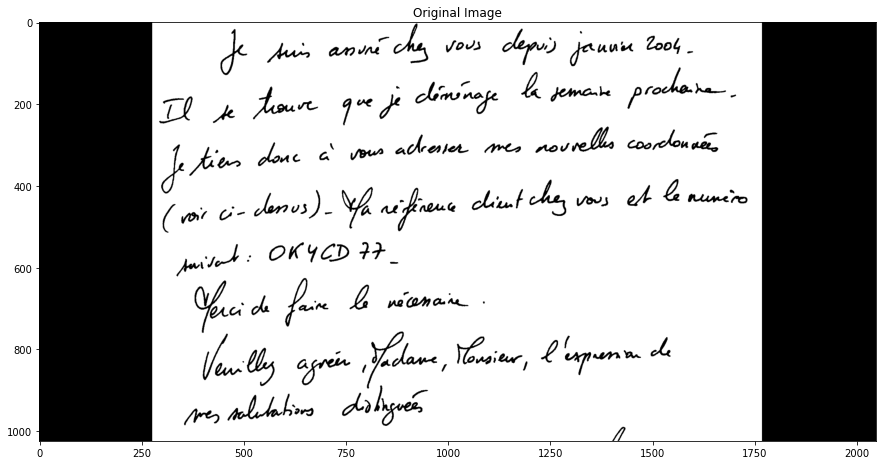

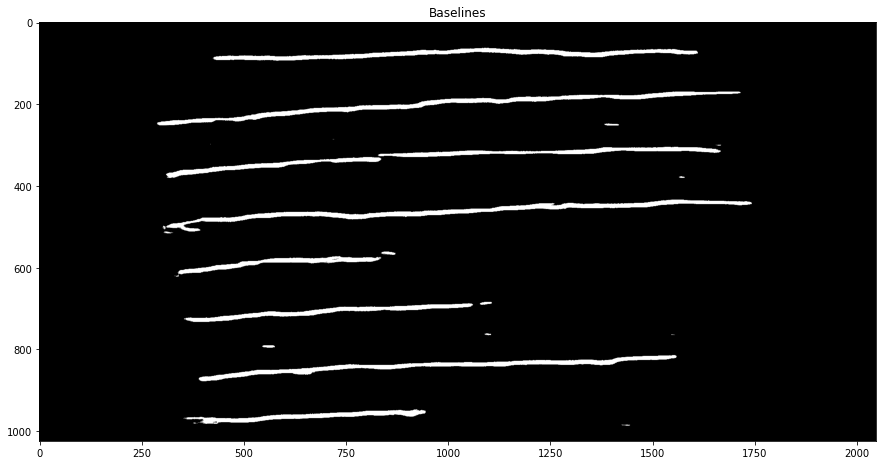

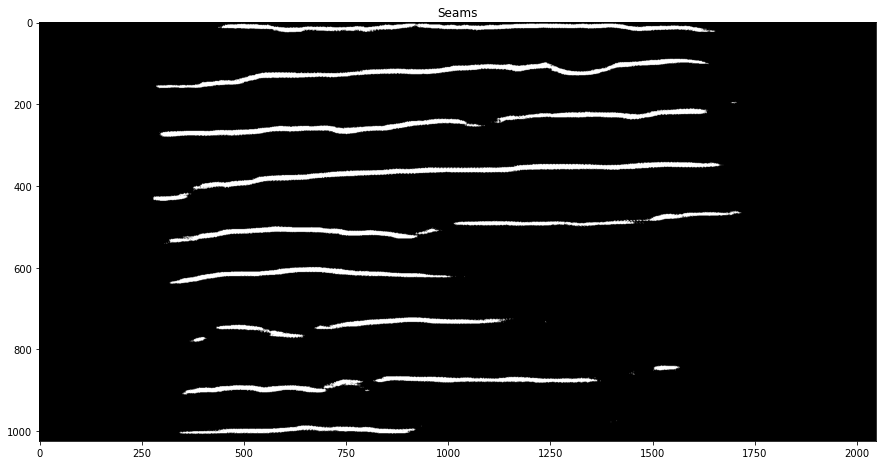

In [ ]:
image, _ = BaselineSequence('/content/baseline_seams_dataset/images', '/content/baseline_seams_dataset/baselines')[7]

print('Predicting Baselines...')
baseline_predictions = baseline_model(tf.expand_dims(image, axis=0))
print('Predicting Seams...')
seam_predictions = seam_model(tf.expand_dims(image, axis=0))

original_image = tf.squeeze(image).numpy()
baseline_image = tf.squeeze(tf.argmax(baseline_predictions, axis=3)).numpy()
seam_image = tf.squeeze(tf.argmax(seam_predictions, axis=3)).numpy()

print('Drawing Figures...')

plt.figure(figsize=(15,15))
plt.title('Original Image')
plt.imshow(original_image, cmap='gray')
plt.pause(.1)

plt.figure(figsize=(15,15))
plt.title('Baselines')
plt.imshow(baseline_image, cmap='gray')
plt.pause(.1)

plt.figure(figsize=(15,15))
plt.title('Seams')
plt.imshow(seam_image, cmap='gray')

With the predictions made from the baseline and seam models, segment each line.

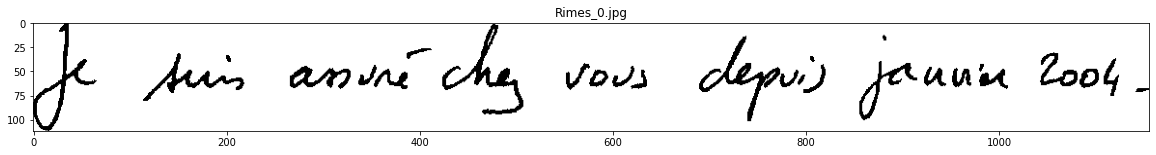

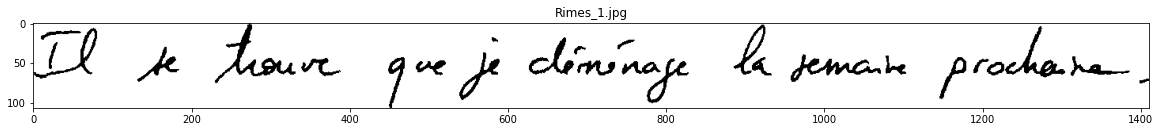

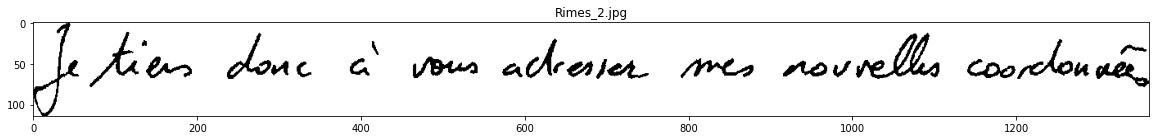

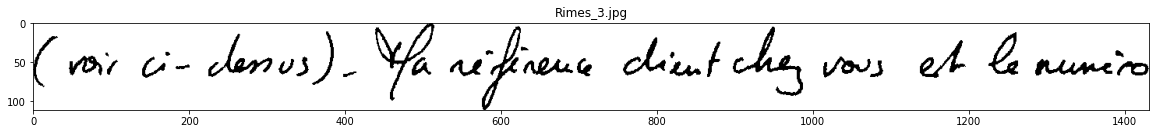

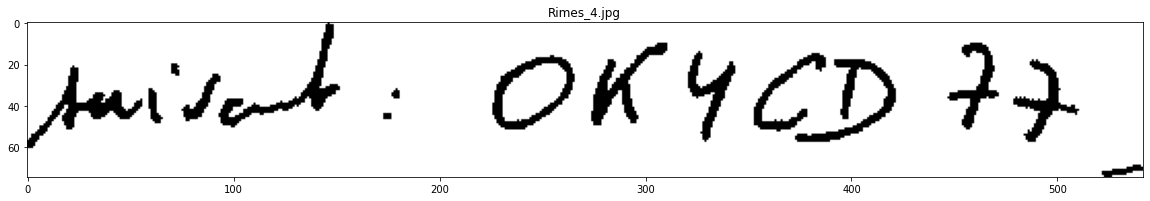

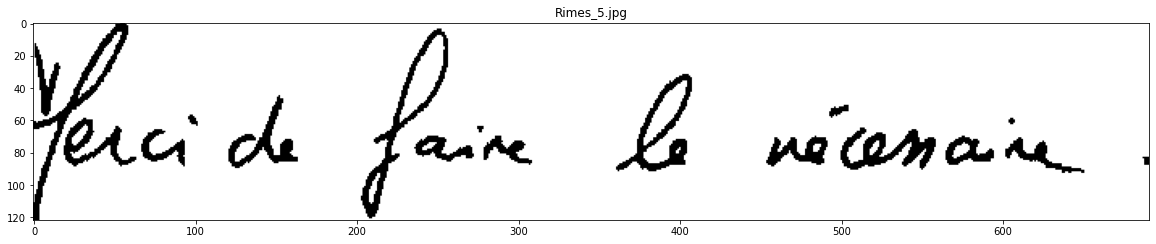

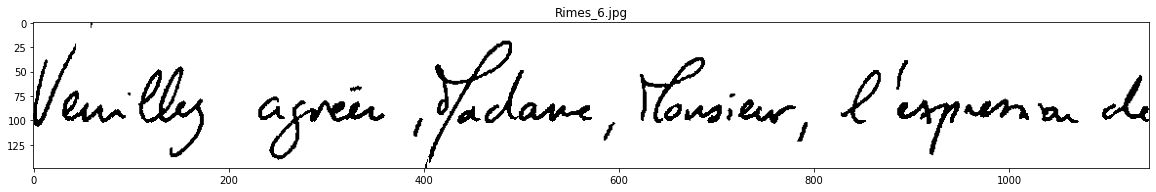

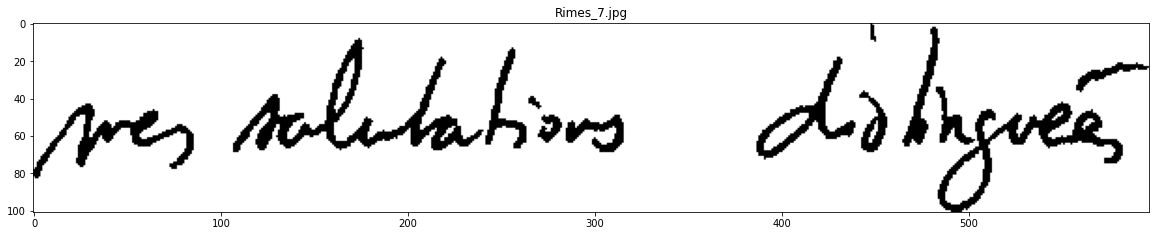

In [ ]:
segment_from_predictions(image, baseline_predictions, seam_predictions, 'Rimes', save_images=False, plot_images=True)

If snippets were saved, you can download them by running this code block.

In [ ]:
from google.colab import files
!zip -r -q /content/image_snippets.zip /content/image_snippets/
files.download('image_snippets.zip')

### Old Code

Old segmentation code that clusters baseline data and draws lines using the
library, *shapely* to determine the top and bottom seams that correspond to a
given baseline.

In [ ]:
def create_segments(original_image, baseline_image, seam_image, image_name, save_images=True, plot_images=False): # Expects Numpy arrays in image format
  print('Calculating baselines from baseline output image...')
  baseline_cluster = cluster(baseline_image)
  print('Calculating seams from seam output image...')
  seam_cluster = cluster(seam_image)

  seams = [LineString(s) for s in seam_cluster]

  for bl in baseline_cluster:
    first_point = Point(bl[0])
    # Consider giving points that aren't right next to each other to create perp line
    first_perp = get_perpendicular_line(LineString(bl[0:2][::-1]), 2000)
    last_point = Point(bl[-1])
    last_perp = get_perpendicular_line(LineString(bl[-2:]), 2000)

    mid_point_index = len(bl) // 2
    mid_point =  Point(bl[mid_point_index])
    mid_perp = get_perpendicular_line(LineString(bl[mid_point_index:mid_point_index + 2]), 2000)

    top_seam, bottom_seam = find_closest_seams(first_point, mid_point, last_point, first_perp, mid_perp, last_perp, seams)

    polygon_points = []
    for coord in top_seam:
      polygon_points.append(coord)
    
    for coord in bottom_seam[::-1]:
      polygon_points.append(coord)

    poly = Polygon(polygon_points)

    image_snippet = segment_from_polygon(poly, Image.fromarray(original_image))
    image_snippet_name = '{}_{}_{}.jpg'.format(image_name, str(int(polygon_points[0][0])), str(int(polygon_points[0][1])))

    if save_images:
      save_image(image_snippet, image_snippet_name)
    if plot_images:
      plot_image(image_snippet, title=image_snippet_name)

In [ ]:
l = LineString([(0,0), (10,0), (15,0)])
p = Point((5,7))
print(p.coords.xy[0][0])
print(p.coords.xy[1][0])

5.0
7.0


In [ ]:
def find_closest_seams(first_point, mid_point, last_point, beg_perp, mid_perp, end_perp, seams):
  distances_seams = []
  for s in seams:
    if mid_perp.intersects(s):
      intersection = s.intersection(mid_perp)
      if type(intersection) is not Point:
        intersection = intersection[0]
      
      distances_seams.append((s.distance(mid_point), intersection.coords[0], s))

  top_dist = None
  top_seam = None
  bottom_dist = None
  bottom_seam = None

  for dist, intersect, seam in distances_seams:
    if is_above(mid_point.coords[0], intersect):
      if top_dist is None or top_dist > dist:
        top_seam = seam
        top_dist = dist
    else:
      if bottom_dist is None or bottom_dist > dist:
        bottom_seam = seam
        bottom_dist = dist

  # Create default seams if none were found
  if top_seam is None:
    # Create straight horizontal line above the baseline with beg/end points
    first = (first_point.coords.xy[0][0], first_point.coords.xy[1][0] - 15)
    mid = (mid_point.coords.xy[0][0], mid_point.coords.xy[1][0] - 15)
    last = (last_point.coords.xy[0][0], last_point.coords.xy[1][0] - 15)
    top_seam = LineString([first, mid, last])
  if bottom_seam is None:
    # Create straight horizontal line above the baseline with beg/end points
    first = (first_point.coords.xy[0][0], first_point.coords.xy[1][0] + 15)
    mid = (mid_point.coords.xy[0][0], mid_point.coords.xy[1][0] + 15)
    last = (last_point.coords.xy[0][0], last_point.coords.xy[1][0] + 15)
    bottom_seam = LineString([first, mid, last])   

  # print(top_seam)
  # print(bottom_seam)

  # Find our intersection points with the above/below seams
  # If we don't quite intersect, create extra points, expand the seam so we can intersect

  # Top-Left
  if beg_perp.intersects(top_seam):
    intersection = beg_perp.intersection(top_seam)
    if type(intersection) is not Point:
      intersection = intersection[0]
    top_left_intersect = Point(intersection.coords[0])
  else:
    left_most_seam_point = top_seam.coords[0]
    new_point_to_add = (first_point.coords[0][0], left_most_seam_point[1])
    top_seam = add_point_to_seam(top_seam, new_point_to_add)
    top_left_intersect = Point(new_point_to_add)

  # Bottom-Left
  if beg_perp.intersects(bottom_seam):
    intersection = beg_perp.intersection(bottom_seam)
    if type(intersection) is not Point:
      intersection = intersection[0]

    bottom_left_intersect = Point(intersection.coords[0])
  else:
    left_most_seam_point = bottom_seam.coords[0]
    new_point_to_add = Point(first_point.coords[0][0], left_most_seam_point[1])
    bottom_seam = add_point_to_seam(bottom_seam, new_point_to_add)
    bottom_left_intersect = Point(new_point_to_add)

  # Top-Right
  if end_perp.intersects(top_seam):
    intersection = end_perp.intersection(top_seam)
    if type(intersection) is not Point:
      intersection = intersection[0]
    top_right_intersect = Point(intersection.coords[0])
  else:
    right_most_seam_point = top_seam.coords[-1]
    new_point_to_add = Point(last_point.coords[0][0], right_most_seam_point[1])
    top_seam = add_point_to_seam(top_seam, new_point_to_add, beginning=False)
    top_right_intersect = Point(new_point_to_add)

  # Bottom-Right 
  if end_perp.intersects(bottom_seam):
    intersection = end_perp.intersection(bottom_seam)
    if type(intersection) is not Point:
      intersection = intersection[0]
    bottom_right_intersect = Point(intersection.coords[0])
  else:
    right_most_seam_point = bottom_seam.coords[-1]
    new_point_to_add = Point(last_point.coords[0][0], right_most_seam_point[1])   
    bottom_seam = add_point_to_seam(bottom_seam, new_point_to_add, beginning=False)
    bottom_right_intersect = Point(new_point_to_add)

  top_seam = split_seam(top_seam, top_left_intersect, top_right_intersect)
  bottom_seam = split_seam(bottom_seam, bottom_left_intersect, bottom_right_intersect)

  return top_seam, bottom_seam

# Change this code to handle exactly vertical lines
def is_above(point, seam_point):
  if point[1] > seam_point[1]:
    return True
  else:
    return False

def get_perpendicular_line(line: LineString, length: int):
    left = line.parallel_offset(length / 2, 'left')
    right = line.parallel_offset(length / 2, 'right')
    point1 = left.boundary[1]
    point2 = right.boundary[0]

    return LineString([point1, point2])

def split_seam(seam, left_point, right_point):
  result = split(seam, left_point)

  # This statement is required in the event that the intersection is the first point in the seam LineString
  if len(result) > 1:
    first_split = LineString(result[1].coords[:])
  else:
    first_split = LineString(result[0].coords[:])

  result = split(first_split, right_point)
  final_split = result[0].coords[:]

  return final_split

def add_point_to_seam(seam, new_point, beginning=True):
  seam_coords = seam.coords[:]
  if beginning:
    seam_coords.insert(0, new_point)
  else:
    seam_coords.append(new_point)

  return LineString(seam_coords)

def save_image(img, path):
  if not os.path.exists(path):
    os.makedirs(path)
  
  img = Image.fromarray(img)
  img.save(path)

def plot_image(img, title=None, figsize=(20,20)):
  plt.figure(figsize=figsize)
  if title is not None:
    plt.title(title)
  plt.imshow(img, cmap='gray')
  plt.pause(.1)

def segment_from_polygon(polygon: Polygon, original_image):
  poly_coords = polygon.exterior.coords[:]
  bounds = polygon.bounds

  blank_img = Image.new("L", original_image.size, 255)
  mask = Image.new("1", original_image.size, 0)
  poly_draw = ImageDraw.Draw(mask)
  poly_draw.polygon(poly_coords, fill=255)

  new_img = Image.composite(original_image, blank_img, mask)
  new_img_cropped = np.array(new_img)[int(bounds[1]):int(bounds[3]), int(bounds[0]):int(bounds[2])]

  return new_img_cropped